In [1]:
import psycopg2
from stm import atomically
from concurrent.futures import ThreadPoolExecutor
from dotenv import dotenv_values
import time
import matplotlib.pyplot as plt
import math

Конфігурація та підключення до бази даних

In [2]:
config = dotenv_values('.env')
conn = psycopg2.connect(
   database=config['POSTGRES_DB'],
   user=config['POSTGRES_USER'], 
   password=config['POSTGRES_PASSWORD'], 
   host=config['POSTGRES_HOST'], 
   port=config['POSTGRES_PORT']
)

Тестові операції для роботи з СУБД

In [3]:
def transfer_funds(from_account, to_account, amount):
    with conn.cursor() as cur:
        @atomically
        def _():
            cur.execute('SELECT balance FROM accounts WHERE id = %s', (from_account,))
            from_balance = cur.fetchone()[0]
            if from_balance < amount:
                raise ValueError('Insufficient balance')
            cur.execute('UPDATE accounts SET balance = balance - %s WHERE id = %s', (amount, from_account))
            cur.execute('UPDATE accounts SET balance = balance + %s WHERE id = %s', (amount, to_account))
            conn.commit()

def credit_funds(to_account_name, amount):
    with conn.cursor() as cur:
        @atomically
        def _():
            cur.execute('UPDATE accounts SET balance = balance + %s WHERE name = %s', (amount, to_account_name))
            conn.commit()

Бенчмарк

In [4]:
def run_transactions(num_threads, num_transactions):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        start_time = time.time()
        
        for i in range(num_transactions):
            futures.append(executor.submit(lambda: transfer_funds(5, 6, 10)))
            futures.append(executor.submit(lambda: transfer_funds(6, 7, 10)))
            futures.append(executor.submit(lambda: transfer_funds(7, 8, 10)))

        for _ in range(math.floor(num_transactions / 2)):
            futures.append(executor.submit(lambda: credit_funds('Lisa', 10)))
            futures.append(executor.submit(lambda: credit_funds('Roman', 10)))

        for future in futures:
            future.result()

        executor.shutdown()
        
        end_time = time.time()
        return end_time - start_time

Main

In [18]:
num_threads = 50
num_transactions = 100
iterations = 50
times = []
for i in range(iterations):
    time_taken = run_transactions(num_threads, num_transactions)
    times.append(time_taken)
    print(f'Completed {num_transactions + num_transactions / 2} transactions in {i+1} iteration in {time_taken:.4f} seconds')

Completed 150.0 transactions in 1 iteration in 0.8091 seconds
Completed 150.0 transactions in 2 iteration in 0.7625 seconds
Completed 150.0 transactions in 3 iteration in 0.6978 seconds
Completed 150.0 transactions in 4 iteration in 0.7467 seconds
Completed 150.0 transactions in 5 iteration in 0.7086 seconds
Completed 150.0 transactions in 6 iteration in 0.7928 seconds
Completed 150.0 transactions in 7 iteration in 0.6747 seconds
Completed 150.0 transactions in 8 iteration in 0.6846 seconds
Completed 150.0 transactions in 9 iteration in 0.7456 seconds
Completed 150.0 transactions in 10 iteration in 0.6917 seconds
Completed 150.0 transactions in 11 iteration in 0.6324 seconds
Completed 150.0 transactions in 12 iteration in 0.7019 seconds
Completed 150.0 transactions in 13 iteration in 0.6302 seconds
Completed 150.0 transactions in 14 iteration in 0.6195 seconds
Completed 150.0 transactions in 15 iteration in 0.6207 seconds
Completed 150.0 transactions in 16 iteration in 0.6220 seconds
C

Побудова графіків

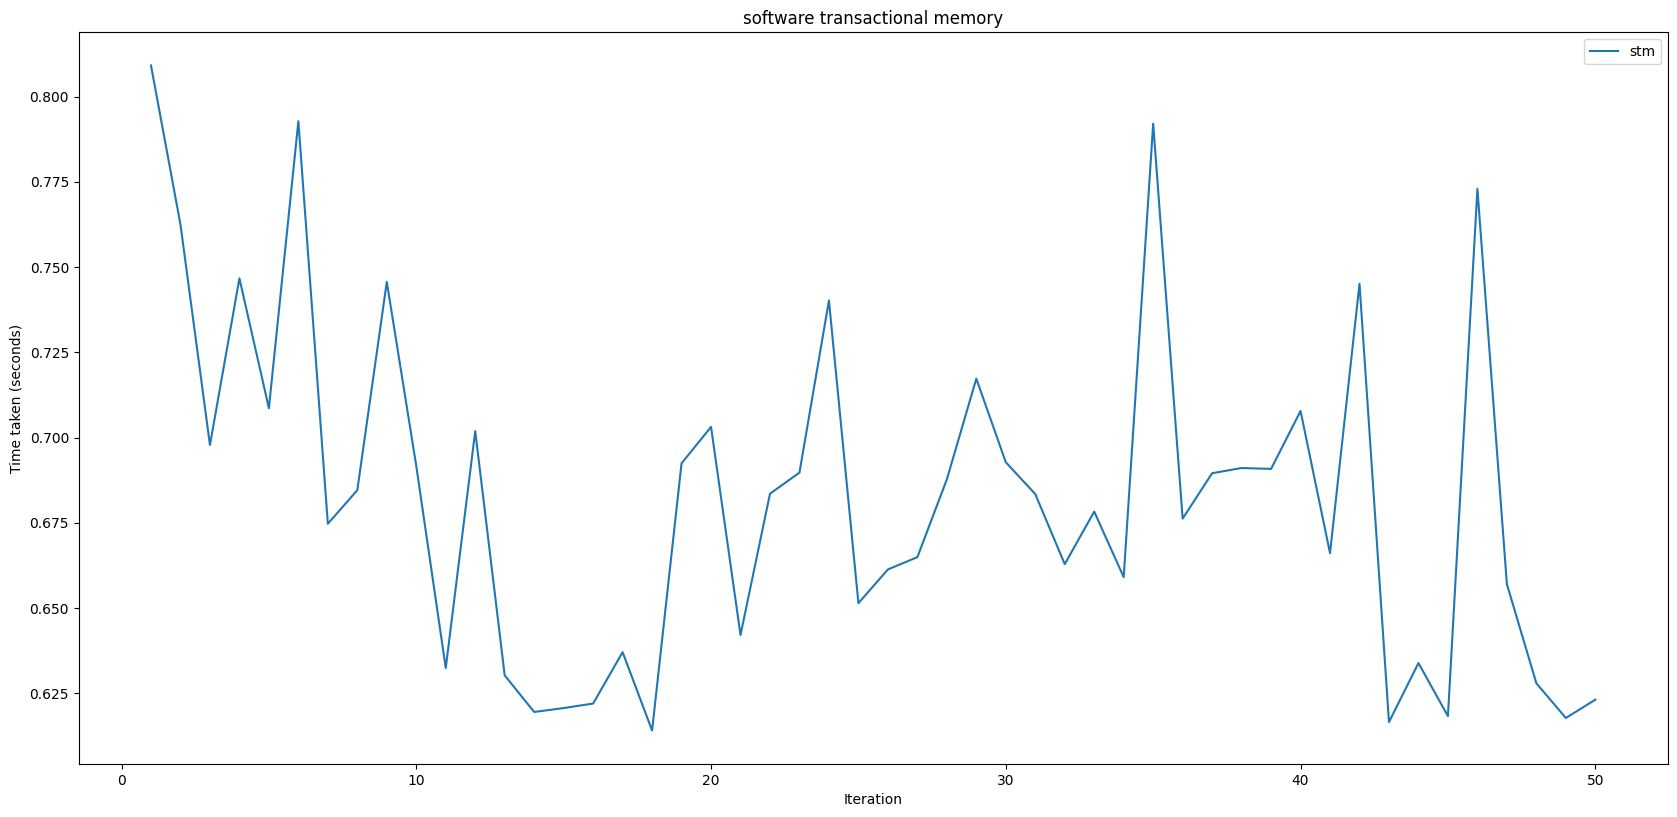

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20.5, 9.5)
ax.plot(range(1, iterations+1), times, label='stm')
ax.set_xlabel('Iteration')
ax.set_ylabel('Time taken (seconds)')

ax.set_title('software transactional memory')
ax.legend()
plt.show()